In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

# 0. Plan działania

Każdy projekt związany z uczeniem maszynowym jest inny, można jednak wyróżnić pewne kroki które zawsze muszą być wykonane:
- Zdobycie zbioru danych
- Zapoznanie się ze zbiorem danych (EDA)
- Przygotowanie danych do analizy (preprocessing)
- Wytrenowanie modelu
- Ewaluacja modelu

Na tych zajęciach przejdziemy przez te kroki dla problemu regresji: przewidzenie ceny domu w Bostonie. 

# 1. Importowanie zbioru danych

In [9]:
boston_dict = load_boston()
print(boston_dict.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


/hdd/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

Widzimy, że otrzymany zbiór danych jest typu `dict`. Sprawdzimy teraz, co znajduje się w tym słowniku i w jaki sposób surowe dane możmy zamienić na obiekt typu `pd.DataFrame` w celu łatwej pracy z nim.

In [24]:
# W tej komórce przejrzyj co znajduje się pod interesującymi Cię kluczami w słowniku
# Pod którym kluczem znajduje się X? Pod którym y?

boston_dict.get('feature_names')

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Wskazówka do komórki poniżej: użyj funkcji `print()`.

In [14]:
# W tej komórce wyświetl opis danych 

print(boston_dict['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Teraz wczytamy wszystkie nasze dane (zarówno $X$ jak i $y$) do obiektu typu `pd.DataFrame`.

In [15]:
boston_df = pd.DataFrame(boston_dict['data'], columns=boston_dict['feature_names'])
boston_df['MEDV'] = boston_dict['target']

In [16]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


# 2. Eksploracyjna analiza danych

W tym momencie wszystkie nasze dane są przechowywane w ramce danych `boston_df`. Użyjemy teraz kolejno metod obiektów `pd.dataframe`: `.head()`, `.info()`, `.describe()` oraz `.hist()` w celu lepszego zapoznania się z danymi. 


In [19]:
# Wywołaj metodę head() na obiekcie boston_df 

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [20]:
# Wywołaj metodę info() na obiekcie boston_df 

boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [21]:
# Wywołaj metodę describe() na obiekcie boston_df 

boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


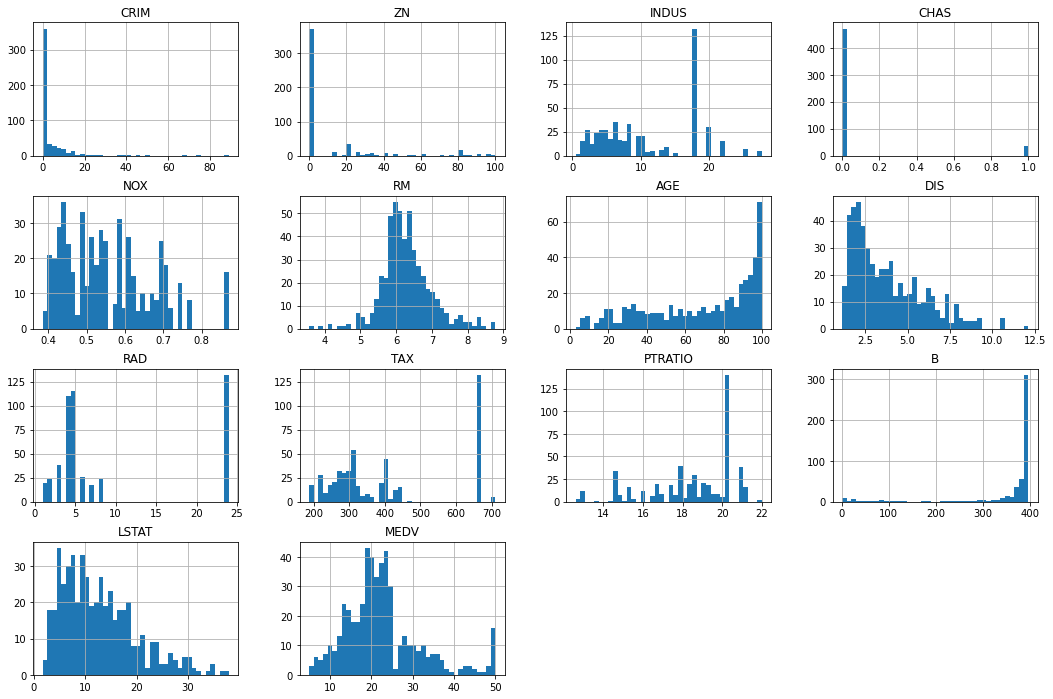

In [22]:
# Wywołaj metodę hist() na obiekcie boston_df 
# Poeksperymentuj z parametrami -- dobrym rozwiązaniem wydają się być wartości (bins = 40, figsize=(18, 12))
# Kod powinien się znajdować powyżej linijki plt.show()

boston_df.hist(bins = 40, figsize=(18, 12))

plt.show()

Ponieważ nasz model będzie modelem regresji liniowej, wartościowe może się okazać przyjrzenie się zależności pomiędzy zmiennymi modelu a zmienną celu. 

Znacie jakiś bardziej elegancki sposób na uzyskanie tego typu wykresów? 

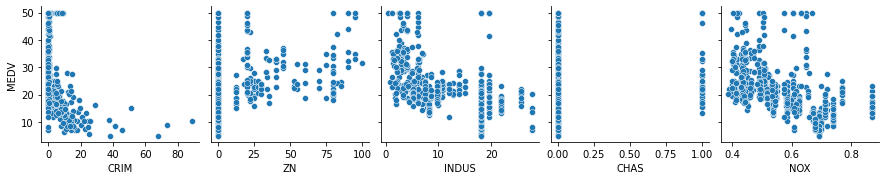

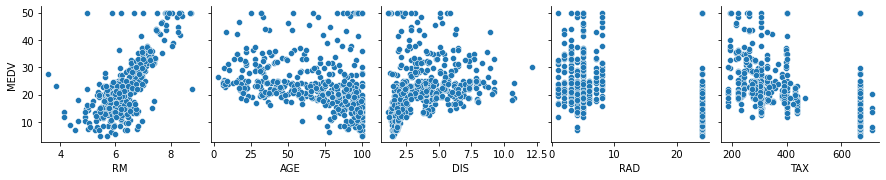

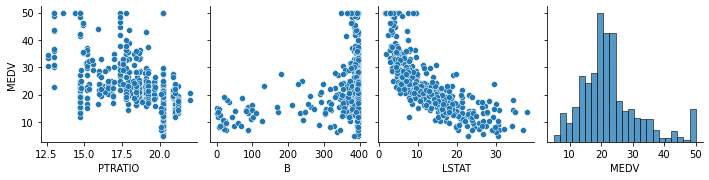

In [23]:
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[:5])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[5:10])
sns.pairplot(boston_df, y_vars="MEDV", x_vars=boston_df.columns.values[10:])

plt.show()

# 3. Przygotowanie zbioru treningowego oraz testowego

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    boston_df[boston_df.columns.values[:-1]], # X
    boston_df[boston_df.columns.values[-1]], # y
    test_size=0.33, random_state=42)

# 4. Preprocessing danych

## 4.1. Po co nam preprocessing danych? 

In [35]:
def plot_linear_model(x, y):
    m = LinearRegression()
    m.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
    y_hat = m.predict(x.values.reshape(-1, 1))
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)
    plt.plot(x, y_hat, c='red')
    plt.xlabel('LSTAT (log lub nie)')
    plt.ylabel('MEDV')
    plt.show()
    plt.close('all')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, y_hat)):.3f}')

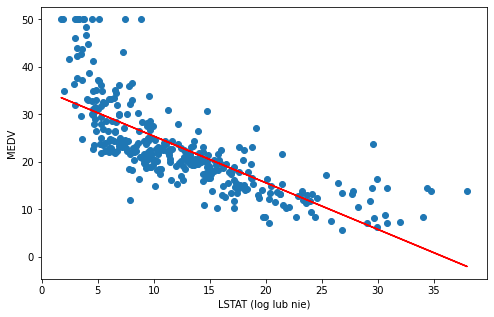

RMSE: 6.222


In [36]:
plot_linear_model(X_train['LSTAT'], y_train)

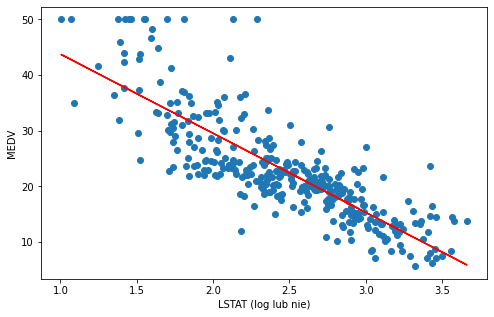

RMSE: 5.307


In [37]:
plot_linear_model(np.log1p(X_train['LSTAT']), y_train)

## 4.2. Właściwy preprocessing danych

Dzięki wywołanej wcześniej metodzie `.info()` wiemy, że w naszym zbiorze danych nie ma braków danych (`506 non-null`). Jedyny preprocessing jaki chcemy wykonać, to transformacja danych.

In [50]:
log_features = ['LSTAT', 'CRIM', 'INDUS', 'NOX']


transformer = ColumnTransformer(
    [
        ('log', FunctionTransformer(np.log1p), log_features)
    ],
    remainder = 'passthrough'
)

# 5. Przygotowanie modelu

## Model liniowy

Wytrenujemy teraz najprostszy model stosowany w problemach regresji: model liniowy. Zostanie on dokładniej omówiony na dalszych zajęciach. Do oceny modelu wykorzystamy miarę **RMSE**. Jest ona zdefiniowana w następujący sposób:

$$ RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^2} $$

Jest to pierwiastek z uśrednionego kwadratu odległości predykcji $\hat{y}$ od wartości prawdziwej $y$. Im niższa wartość, tym lepiej.


In [51]:
pipe_simple = Pipeline(
    [
        ('linear-model', LinearRegression())
    ]
)

pipe_transformer = Pipeline(
    [
        ('transformer', transformer),
        ('linear-model', LinearRegression())
    ]
)


In [52]:
pipe_simple.fit(X_train, y_train)
y_test_hat = pipe_simple.predict(X_test)

print(f'RMSE (bez transformacji danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')

RMSE (bez transformacji danych): 4.552


In [53]:
pipe_transformer.fit(X_train, y_train)
y_test_hat = pipe_transformer.predict(X_test)

print(f'RMSE (z transformacją danych): {np.sqrt(mean_squared_error(y_test, y_test_hat)):.3f}')

RMSE (z transformacją danych): 4.193


Możemy zaobserwować, że transformując część zmiennych udało nam się osiągnąć niższą wartość RMSE. 

## Baseline

Skąd wiemy że nasz model radzi sobie dobrze? Standardową strategią w takiej sytuacji jest wybór baselinu, czyli bardzo prostej metody, którą chcemy "przebić". W naszym przypadku, jako baseline przyjmiemy stałą która minimalizuje RMSE.  

Zadanie: Jaka stała minimalizuje RMSE?

$$RMSE(a) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} (a - y_i)^2}$$

$$\min(RMSE(a)) = \min(\sqrt{\frac{1}{N}\sum_{i=1}^{N} (a - y_i)^2}) = \min (\sum_{i=1}^{N} (a - y_i)^2)$$

$$(\sum_{i=1}^{N} (a - y_i)^2)' = \sum_{i=1}^{N} (2a - 2y_i)$$

$$\sum_{i=1}^{N} (2a - 2y_i) = 0$$

$$ \sum_{i=1}^{N} y_i = N\cdot a$$

$$a = \frac{1}{N} \sum_{i=1}^{N} y_i$$

In [57]:
##TODO: obliczenie baselinu dla zbioru i porównanie go z modelem

y_test_hat = np.ones_like(y_test) * np.mean(y_train) # ones_like po to, aby mieć ten sam wymiar macierzy

np.sqrt(mean_squared_error(y_test, y_test_hat))

8.799980682431661